In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.stats import ttest_ind

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
# We can view all of the classes that automap found
Base.classes.keys()
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [16]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [21]:
#First I need to figure out what the variables are in each table
#Measurement Table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [22]:
#Station Table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).\
            order_by(measurement.date.desc()).first()

date_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)


print(f"The last date is {last_date[0]}, therefore the date 1 year ago from that date is {year_ago}")



The last date is 2017-08-23, therefore the date 1 year ago from that date is 2016-08-23


In [38]:
# Perform a query to retrieve the data and precipitation scores

measurement_columns = (measurement.date, measurement.prcp)

prcp_data = session.query(*measurement_columns).\
            filter(measurement.date >= date_year_ago).\
            order_by(measurement.date.desc()).all()
prcp_data[:10]



[('2017-08-23', 0.0),
 ('2017-08-23', 0.0),
 ('2017-08-23', 0.08),
 ('2017-08-23', 0.45),
 ('2017-08-22', 0.0),
 ('2017-08-22', 0.0),
 ('2017-08-22', 0.5),
 ('2017-08-21', 0.0),
 ('2017-08-21', 0.02),
 ('2017-08-21', None)]

In [42]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data,columns=['Date','Precipitation'])
prcp_df.set_index('Date', inplace=True)
prcp_df.sort_values('Date', inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN


/Users/daltonfield/opt/anaconda3/envs/PythonData/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


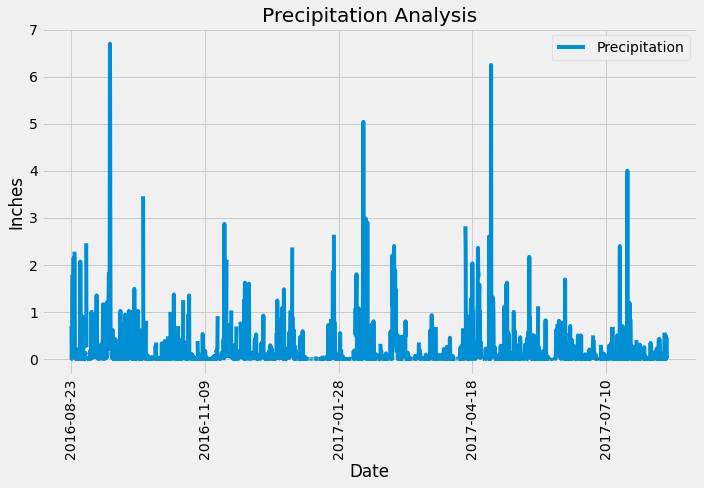

<Figure size 432x288 with 0 Axes>

In [53]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation Analysis", figsize=(10,7))
plt.legend(loc='upper right')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

plt.savefig("Images/precipitation_graph.png")


In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [64]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(station.id)).all()
print(f' There are {station_count[0]} stations in the dataset')

 There are (9,) stations in the dataset


In [67]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()
most_active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [69]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [72]:
# Choose the station with the highest number of temperature observations.
highest_num_temp = session.query(measurement.date,(measurement.tobs)).\
                          filter(measurement.date >= date_year_ago ).\
                          filter(measurement.station == "USC00519281").group_by(measurement.date).all()

highest_num_temp_df = pd.DataFrame(highest_num_temp, columns=["Date", "TOBS"])
highest_num_temp_df.sort_values('TOBS', inplace=True, ascending=False)
highest_num_temp_df.head()


,Date,TOBS
345,2017-08-06,83.0
344,2017-08-05,82.0
340,2017-07-29,82.0
334,2017-07-23,82.0
313,2017-07-02,81.0


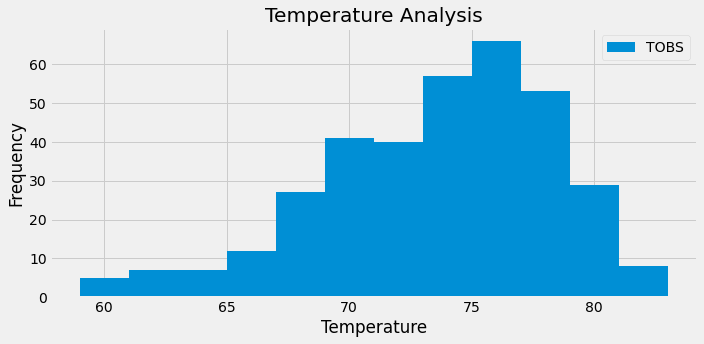

<Figure size 432x288 with 0 Axes>

In [74]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_num_temp_df.plot.hist(title = "Temperature Analysis", bins=12, figsize=(10,5))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
plt.savefig("Images/temperature_graph.png")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
